# 8.뉴스 요약봇 만들기

In [1]:
! pip install keras-tuner

## 데이터 준비
뉴스 요약에 사용하고자 하는 [데이터](https://github.com/sunnysai12345/News_Summary)는 2017년 2월부터 8월 사이에 `The Hindu`, `Indiantimes`와 `Guardian`지에 실린 기사를 수집한 것입니다.  
데이터의 출처가 인도 언론임을 감안하고 데이터를 사용해야 할 것으로 보입니다.


In [2]:
import pandas as pd
import urllib.request


urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv",
    filename="news_summary_more.csv",
)
data = pd.read_csv("news_summary_more.csv", encoding="iso-8859-1")

In [3]:
print(len(data))
data.sample(10, random_state=2049)

98401


,headlines,text
85878,CEATÃ¢ÂÂs new witty videos can help you save...,CEAT Tyres has released a new range of light-h...
9189,RBI board's decisions will be positive for eco...,Kotak Mahindra Bank's MD and CEO Uday Kotak we...
77495,Wells Fargo cuts 69 top executive jobs post ac...,"US bank Wells Fargo, recently hit by a fraudul..."
51516,"In the end, truth wins: Delhi CM on 'office of...",Delhi Chief Minister Arvind Kejriwal on Friday...
6147,Made my peace with her: Deepika on Katrina att...,Talking about her relationship with Katrina Ka...
56751,Do not enjoy dealing with Pakistan: US State Secy,US State Secretary Rex Tillerson has said that...
52254,FBI once sent letter to Martin Luther urging h...,American civil rights activist Martin Luther K...
84847,Waves hit journo reporting about 'destructive'...,A Kerala journalist was hit by waves from the ...
60802,Pakistan fired 500 missiles in our territory: ...,Afghanistan on Wednesday said Pakistan fired o...
72120,CPI-M chooses CM of 19 years as candidate for ...,The Communist Party of India-Marxist (CPI-M) h...


데이터는 총 98401개의 헤드라인과 본문으로 구성되어 있습니다.  
인코딩 문제로 정상적으로 출력되지 않는 글자들이 보입니다. 또한 문장 부호와 숫자들이 존재합니다.  
해당 데이터에 대해 추후 전처리가 필요합니다.

In [4]:
for i in [1188, 21325]:  # 1193
    print(data["text"][i])
    print()

Tabu, who played dark characters in films like 'Maachis', 'Haider' and 'AndhaDhun', said, "Playing dark characters has become a thing now for female actors. When I was doing it, no one else was." "It was not that I was trying to break the glass ceiling. Ye sab bas hota gaya and female characters ke liye base banta gaya," she added.

Following Atal Bihari Vajpayee's demise, Sachin Tendulkar tweeted, "India is at a great loss today.Shri #AtalBihariVajpayee ji's contributions to our nation have been innumerable." "Asaman ko choo gaya, jo asmaan sa vishal tha, dharti mein simat gaya, jo mitti jaisa narm tha. Kaun hai jo Atal reh paya zindagi bhar, Atal banke wo zindagi ko paa gaya," Virender Sehwag tweeted.



많은 단어들이 영어로 되어있지만, 문장이나 발언을 인용하는 경우 힌디어와 영어가 합성된 "[Hinglish](https://en.wikipedia.org/wiki/Hinglish)"가 발견됩니다.
해당 언어에 대한 불용어 처리도 필요하다고 판단됩니다.

In [5]:
print(data["headlines"].nunique())
print(data["text"].nunique())

98280
98360


헤드라인에 대해서는 중복이 존재할 수 있으나, 본문에 대한 중복은 피하는 편이 좋으니 제거합니다.

In [6]:
data.drop_duplicates(subset=["text"], inplace=True)
print(len(data))

98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


데이터셋에 null 샘플은 존재하지 않아 별도의 처리가 필요하지 않습니다.

## 데이터 전처리

동일한 의미를 나타내는 단어들을 동일한 형태로 변환시켜주는 텍스트 정규화를 준비합니다.

In [8]:
contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어는 일반적으로 자연어 처리에 도움이 되지 않습니다. nltk에서 제공하는 정보를 사용하여 전처리 과정에서 불용어 제거를 적용합니다.  
앞서 확인한 바와 같이 Hinglish에 대한 불용어 처리도 준비합니다. [(Hinglish 불용어 출처)](https://github.com/TrigonaMinima/HinglishNLP)

In [9]:
import nltk
from nltk.corpus import stopwords
import re
import numpy as np


nltk.download("stopwords")
print("영어 불용어 개수 :", len(stopwords.words("english")))
print(stopwords.words("english")[:100])
print()

with open("hingl.txt") as f:
    hinglish = f.read().splitlines()
print("Hinglish 불용어 개수:", len(hinglish))
print(hinglish[:100])
print()

stopwords_ext = list(set(stopwords.words("english") + hinglish))
print("합쳐진 불용어 개수:", len(stopwords_ext))
print(stopwords_ext[:100])

영어 불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']

Hinglish 불용어 개수: 1036
['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'ac

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


데이터 전처리를 수행하는 함수를 선언합니다.
1. 모든 문자를 소문자로 치환
2. 괄호로 감싸진 문자열 제거
3. 큰따옴표 제거
4. 축약어 제거
5. 소유격 제거
6. 영어 외 문자 공백으로 치환
7. 불용어 제거


In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = re.sub(r"\([^)]*\)", "", sentence)
    sentence = re.sub('"', "", sentence)
    sentence = " ".join(
        [contractions[t] if t in contractions else t for t in sentence.split(" ")]
    )
    sentence = re.sub(r"'s\b", "", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    if remove_stopwords:
        tokens = " ".join(
            word
            for word in sentence.split()
            if not word in stopwords_ext
            if len(word) > 1
        )
    else:
        tokens = " ".join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 함수를 테스트합니다.  

In [11]:
idx = 26
temp_text = data["text"][idx]
temp_headline = data["headlines"][idx]

print("text (orig)    :", temp_text)
print("text           :", preprocess_sentence(temp_text))
print("headline (orig):", temp_headline)
print("headline       :", preprocess_sentence(temp_headline, False))

text (orig)    : A London zoo is offering people to name a cockroach after their exes on Valentine's Day for ÃÂ£1.50 (nearly Ã¢ÂÂ¹140). "For those that don't quite require revenge, there's another way to make you feel better about getting back at your ex," the zoo said in a statement. The names will appear on zoo's 'roach board' on February 14. 
text           : london zoo offering cockroach exes valentine day require revenge make feel back zoo statement names zoo roach board february
headline (orig): UK zoo offers people to name cockroach after their ex on Valentine's
headline       : uk zoo offers people to name cockroach after their ex on valentine


전처리 함수에 선언되어 있는 내용과 같이 소문자 변환, 문장부호 제거 등이 적용되었음을 확인할 수 있습니다. 또한 앞서 확인했던 인코딩 문제로 정상적이지 않은 문자 역시 제거되었습니다.  
요약에 대해서는 불용어 제거를 수행하지 않아 "to"와 같은 단어들이 남아있습니다.

전체 `text` 데이터에 대해서 전처리를 적용합니다.

In [12]:
clean_text = []
for s in data["text"]:
    clean_text.append(preprocess_sentence(s))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy year pranav kaushik delhi techie bagged reward spending cred coins users cred coin rupee bill paid avail rewards brands ixigo bookmyshow ubereats cult fit', 'zealand defeated india wickets fourth odi hamilton thursday win match match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan life cover age years customers options insure critical illnesses disability accidental death benefit rider life co

`headlines` 데이터에 대해 전처리를 적용하지만 불용어 제거는 수행하지 않습니다.

In [13]:
clean_summary = []
for s in data["headlines"]:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


전처리의 결과로 문자열에 아무것도 없는 경우가 생길 수 있고, 비어있는 문자열이 존재하는지 확인합니다.

In [14]:
data["text"] = clean_text
data["headlines"] = clean_summary

data.replace("", np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print("전체 샘플수 :", (len(data)))

전체 샘플수 : 98360


최대 길이 제한을 정하기 위해 본문과 요약에 대한 통계를 확인합니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 49
텍스트의 평균 길이 : 30.859414396095975
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


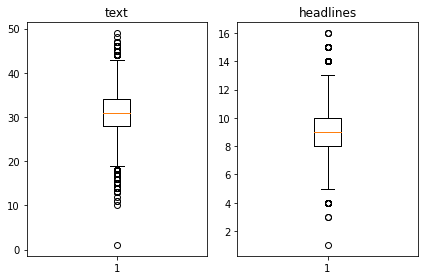

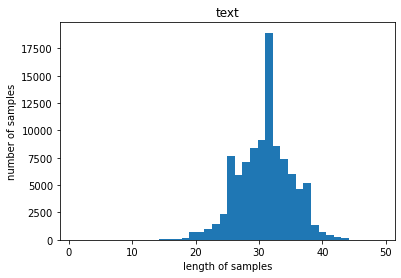

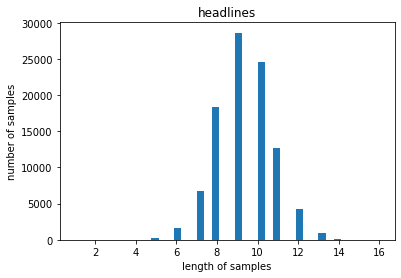

In [16]:
import matplotlib.pyplot as plt


text_len = [len(s.split()) for s in data["text"]]
summary_len = [len(s.split()) for s in data["headlines"]]

print("텍스트의 최소 길이 : {}".format(np.min(text_len)))
print("텍스트의 최대 길이 : {}".format(np.max(text_len)))
print("텍스트의 평균 길이 : {}".format(np.mean(text_len)))
print("요약의 최소 길이 : {}".format(np.min(summary_len)))
print("요약의 최대 길이 : {}".format(np.max(summary_len)))
print("요약의 평균 길이 : {}".format(np.mean(summary_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title("text")
plt.subplot(1, 2, 2)
plt.boxplot(summary_len)
plt.title("headlines")
plt.tight_layout()
plt.show()

plt.title("text")
plt.hist(text_len, bins=40)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

plt.title("headlines")
plt.hist(summary_len, bins=40)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

텍스트는 평균 길이가 30 이지만 값이 분포하는 범위가 넓은 것으로 확인됩니다.  
텍스트 데이터의 최대 길이 제한은 49 보다 작은 40 으로 정합니다.  
요약 데이터의 최대 길이 제한은 16 보다 작은 12 로 정합니다.  
(각각은 약 80%의 비율로 임의로 설정한 수치입니다.)

In [17]:
text_max_len = 40
summary_max_len = 12

지정한 최대 길이보다 짧은 데이터의 비율이 얼마나 되는지 확인합니다.

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s.split()) <= max_len:
            cnt = cnt + 1
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s" % (max_len, (cnt / len(nested_list))))


below_threshold_len(text_max_len, data["text"])
below_threshold_len(summary_max_len, data["headlines"])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9915209434729565
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


텍스트 데이터는 길이가 40 이하인 샘플의 비율이 99.15%로 대부분의 샘플이 40 이하의 길이를 가지고 있습니다.  
요약 데이터의 경우 길이가 12 이하인 샘플은 98.80%입니다.

패딩 과정에서 시퀀스(문장)을 자르면 불완전한 문장이 될 가능성이 높기에, 길이 조건을 만족하지 못하는 문장 자체를 데이터에서 제외합니다.

In [19]:
data = data[data["text"].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data["headlines"].apply(lambda x: len(x.split()) <= summary_max_len)]
print("전체 샘플수 :", (len(data)))

전체 샘플수 : 96354


요약 데이터에 문장 시작과 끝을 알려주는 토큰(`sostoken`, `eostoken`)을 추가합니다.

In [20]:
data["decoder_input"] = data["headlines"].apply(lambda x: "sostoken " + x)
data["decoder_target"] = data["headlines"].apply(lambda x: x + " eostoken")
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,zealand defeated india wickets fourth odi hami...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


인코더에서 사용할 데이터와 디코더에서 사용할 데이터를 준비합니다.

In [21]:
encoder_input = np.array(data["text"])
decoder_input = np.array(data["decoder_input"])
decoder_target = np.array(data["decoder_target"])

## 훈련 데이터와 검증 데이터 분리
검증 데이터 준비를 위해 훈련 데이터의 인덱스를 임의로 섞고, 20%를 분리합니다.

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[87613 17800 31548 ...  7693 44779 18762]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input) * 0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print("훈련 데이터의 개수 :", len(encoder_input_train))
print("훈련 레이블의 개수 :", len(decoder_input_train))
print("테스트 데이터의 개수 :", len(encoder_input_test))
print("테스트 레이블의 개수 :", len(decoder_input_test))

훈련 데이터의 개수 : 77084
훈련 레이블의 개수 : 77084
테스트 데이터의 개수 : 19270
테스트 레이블의 개수 : 19270


## 정수 인코딩
준비된 훈련 데이터를 위한 단어 집합을 생성합니다.

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

등장 빈도가 낮은 단어를 훈련 데이터에서 제외시키기 위해 각 단어의 등장 빈도를 확인합니다.

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print(f"등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}")
print("단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: ", (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 68188
등장 빈도가 6번 이하인 희귀 단어의 수: 46706
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기:  21482
단어 집합에서 희귀 단어의 비율: 68.49592303631138
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9887887341272394


희귀 단어를 제외한 경우 단어 집합의 크기가 22,095이 되고, 근사한 값인 20,000으로 단어 집합의 크기를 제한합니다.

In [27]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

크기가 제한된 단어 집합을 사용하여 텍스트 시퀀스를 변환합니다.

In [28]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[794, 14245, 6943, 8391, 4266, 3785, 9372, 10504, 6943, 41, 79, 1141, 1168, 12038, 1, 1088, 1141, 755, 439, 18824, 84, 111, 1473, 3599, 83, 1141, 218, 1678, 18825, 91, 1, 11013, 3], [122, 11, 54, 11014, 1716, 7458, 2101, 5988, 1396, 6, 6744, 1269, 14246, 8251, 2342, 691, 402, 1397, 4441, 1716, 728, 2123, 2789, 33, 501, 3630, 2861, 2465, 652, 8671, 305, 1396, 383], [2962, 2041, 267, 100, 3529, 8856, 5479, 8392, 1063, 2188, 4671, 3529, 197, 1339, 147, 293, 315, 1, 320, 5479, 4198, 2789, 1353, 1689, 185, 137, 67]]


디코더 입력 데이터에 대해서도 희귀 단어를 확인하고 단어장의 크기를 결정하는 과정을 진행합니다.

In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print(f"등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}")
print("단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: ", (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 29923
등장 빈도가 6번 이하인 희귀 단어의 수: 20521
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기:  9402
단어 집합에서 희귀 단어의 비율: 68.57935367443105
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.445860114282245


디코더 입력 데이터에 대해서는 단어 집합의 크기를 9,000으로 정했습니다.

In [31]:
tar_vocab = 9000

tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print("input ", decoder_input_train[:5])
print("decoder ", decoder_target_train[:5])

input  [[1, 559, 2499, 5, 8, 6778, 890, 5569], [1, 963, 121, 3, 2500, 6403, 7, 2811, 4084], [1, 349, 563, 2168, 257, 25, 8676, 7148, 5817], [1, 105, 1225, 187, 6122, 3740, 9, 1315], [1, 279, 5149, 1685, 4948, 4, 347, 1015]]
decoder  [[559, 2499, 5, 8, 6778, 890, 5569, 2], [963, 121, 3, 2500, 6403, 7, 2811, 4084, 2], [349, 563, 2168, 257, 25, 8676, 7148, 5817, 2], [105, 1225, 187, 6122, 3740, 9, 1315, 2], [279, 5149, 1685, 4948, 4, 347, 1015, 2]]


등장 빈도가 낮은 단어들을 제외시켰기 때문에, 해당 단어들로만 구성된 문장은 길이가 0이 되었을 것입니다.  
따라서 길이가 0(`sostoken` 또는 `eostoken`을 제외)인 데이터를 제거합니다.

In [32]:
drop_train = [
    index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1
]
drop_test = [
    index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1
]

print("삭제할 훈련 데이터의 개수 :", len(drop_train))
print("삭제할 테스트 데이터의 개수 :", len(drop_test))

encoder_input_train = [
    sentence
    for index, sentence in enumerate(encoder_input_train)
    if index not in drop_train
]
decoder_input_train = [
    sentence
    for index, sentence in enumerate(decoder_input_train)
    if index not in drop_train
]
decoder_target_train = [
    sentence
    for index, sentence in enumerate(decoder_target_train)
    if index not in drop_train
]

encoder_input_test = [
    sentence
    for index, sentence in enumerate(encoder_input_test)
    if index not in drop_test
]
decoder_input_test = [
    sentence
    for index, sentence in enumerate(decoder_input_test)
    if index not in drop_test
]
decoder_target_test = [
    sentence
    for index, sentence in enumerate(decoder_target_test)
    if index not in drop_test
]

print("훈련 데이터의 개수 :", len(encoder_input_train))
print("훈련 레이블의 개수 :", len(decoder_input_train))
print("테스트 데이터의 개수 :", len(encoder_input_test))
print("테스트 레이블의 개수 :", len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77084
훈련 레이블의 개수 : 77084
테스트 데이터의 개수 : 19270
테스트 레이블의 개수 : 19270


시퀀스의 최대 길이를 제한하며, 길이가 부족한 시퀀스에 대해서는 패딩을 수행합니다.

In [33]:
encoder_input_train = pad_sequences(
    encoder_input_train, maxlen=text_max_len, padding="post"
)
encoder_input_test = pad_sequences(
    encoder_input_test, maxlen=text_max_len, padding="post"
)
decoder_input_train = pad_sequences(
    decoder_input_train, maxlen=summary_max_len, padding="post"
)
decoder_target_train = pad_sequences(
    decoder_target_train, maxlen=summary_max_len, padding="post"
)
decoder_input_test = pad_sequences(
    decoder_input_test, maxlen=summary_max_len, padding="post"
)
decoder_target_test = pad_sequences(
    decoder_target_test, maxlen=summary_max_len, padding="post"
)

## 모델 설계
모델의 인코더를 설계합니다.  
- seq2seq 구조에 attention을 추가한 구조를 사용하겠습니다.  
- 인코더에서 LSTM은 3개의 층을 사용하였습니다.

In [34]:
from tensorflow.keras.layers import (
    Input,
    Embedding,
    LSTM,
    Dense,
    AdditiveAttention,
    Concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(
    hidden_size,
    return_sequences=True,
    return_state=True,
    dropout=0.4,
)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(
    hidden_size,
    return_sequences=True,
    return_state=True,
    dropout=0.4,
)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(
    hidden_size,
    return_state=True,
    return_sequences=True,
    dropout=0.4,
)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

모델의 디코더를 설계합니다.  
- 성능 향상을 위해서 attention 기법을 사용합니다.

In [35]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(
    hidden_size,
    return_sequences=True,
    return_state=True,
    dropout=0.4,
)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

attn_layer = AdditiveAttention(name="attention_layer")
attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name="concat_layer")(
    [decoder_outputs, attn_out]
)
decoder_softmax_layer = Dense(tar_vocab, activation="softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 모델 훈련

In [36]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
es = EarlyStopping(monitor="val_loss", patience=2, verbose=1)

history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[es],
    epochs=50,
)

Epoch 1/50
302/302 [==============================] - 34s 90ms/step - loss: 5.5325 - val_loss: 5.1157
Epoch 2/50
302/302 [==============================] - 26s 88ms/step - loss: 4.9627 - val_loss: 4.7924
Epoch 3/50
302/302 [==============================] - 27s 90ms/step - loss: 4.6200 - val_loss: 4.5193
Epoch 4/50
302/302 [==============================] - 27s 89ms/step - loss: 4.3543 - val_loss: 4.3321
Epoch 5/50
302/302 [==============================] - 27s 89ms/step - loss: 4.1500 - val_loss: 4.1938
Epoch 6/50
302/302 [==============================] - 27s 90ms/step - loss: 3.9830 - val_loss: 4.0980
Epoch 7/50
302/302 [==============================] - 27s 90ms/step - loss: 3.8398 - val_loss: 3.9919
Epoch 8/50
302/302 [==============================] - 27s 91ms/step - loss: 3.7141 - val_loss: 3.9111
Epoch 9/50
302/302 [==============================] - 27s 91ms/step - loss: 3.6048 - val_loss: 3.8587
Epoch 10/50
302/302 [==============================] - 27s 91ms/step - loss: 3.506

훈련 결과를 그래프로 확인합니다

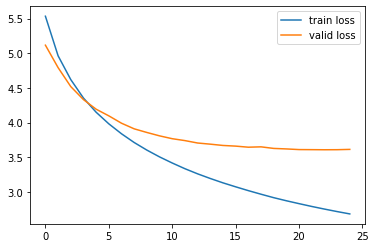

In [37]:
import matplotlib.pyplot as plt


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

총 50 epoch 중 25 epoch 이후 훈련을 중단하였습니다.(validation loss가 2 epoch 동안 감소하지 않음)    
그래프를 보면 5 epoch 부근을 기준으로 학습이 진행되면서 validation loss와 train loss의 차이가 점점 벌어짐을 확인할 수 있습니다.(과적합 양상으로 판단됩니다.)  
최종 validation loss는 3.62으로 첫 epoch 이후 얻었던 5.12과 비교하여 약 1.50 정도 감소하였습니다.

## 모델 테스트

테스트를 위해 아래의 3가지 항목을 준비합니다.
1. 텍스트 원문 단어 집합을 참고하여 숫자를 단어로 변환하는 사전
2. 요약문 단어 집합을 참고하여 단어를 숫자로 변환하는 사전
3. 요약문 단어 집합을 참고하여 숫자를 단어로 변환하는 사전


In [38]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

테스트를 위한 인코더 설계

In [39]:
encoder_model = Model(
    inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c]
)

테스트를 위한 디코더 설계

In [40]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name="concat")(
    [decoder_outputs2, attn_out_inf]
)

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs]
    + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2],
)

모델의 테스트를 위해 디코딩 함수를 작성합니다.  
- `target_seq`에 `sostoken`에 해당하는 토큰을 입력합니다.
- 입력 데이터에 대한 모델의 출력 결과를 모델에 다시 입력으로 사용하여 문장을 생성합니다.

In [41]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index["sostoken"]

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != "eostoken":
            decoded_sentence += " " + sampled_token
        if sampled_token == "eostoken" or len(decoded_sentence.split()) >= (
            summary_max_len - 1
        ):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

## 실제 결과와 요약문 비교하기
모델을 통해서 얻은 결과와 실제 데이터를 비교하기 위한 함수를 작성합니다.
1. (원문) 정수로 표현된 데이터를 텍스트로 변환하는 함수
2. (요약) 정수로 표현된 데이터를 요약문으로 변환하는 함수

In [42]:
def seq2text(input_seq):
    temp = ""
    for i in input_seq:
        if i != 0:
            temp = temp + src_index_to_word[i] + " "
    return temp


def seq2summary(input_seq):
    temp = ""
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index["sostoken"]) and i != tar_word_to_index[
            "eostoken"
        ]:
            temp = temp + tar_index_to_word[i] + " "
    return temp

In [43]:
for i in range(78, 83):
    print("원문      :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문      : comedian turned actor andy dick fired movies accused sexual misconduct harassment sets andy accused groping consensual kissing kissed cheek bye funny 
실제 요약 : comedian andy fired from films post sexual misconduct claims 
예측 요약 :  am not my friend weinstein on sexual harassment


원문      : janhvi kapoor talking school days school days make stories remember calling friend secret agent spy school believe added 
실제 요약 : in school days people thought was janhvi 
예측 요약 :  have been to be for the class of kids janhvi


원문      : england ended day fourth test innings trailing india runs india cheteshwar pujara scored maiden test ton england pujara scored registered run run stand ninth tenth wickets respectively england moeen ali picked indian wickets runs 
실제 요약 : england trail by runs after pujara scores st ton in eng 
예측 요약 :  pujara end day as england end day at home


원문      : virat kohli playing test captain south africa johannesburg fielded different playing xi tests kohli dif

validation loss가 3.62인 모델의 출력 결과는 요약문에 포함되어 있는 핵심 단어를 포함하는 경우도 있었으나, 전하고자 하는 내용을 전달하지 못하는 경우가 많았습니다.  
더 낮은 validation loss를 달성한 모델의 요약 결과는 어떤지 확인하기 위해 모델 탐색을 수행합니다.

## 모델 탐색

In [44]:
import tensorflow as tf
import keras_tuner as kt
import IPython


trials = 24


def model_builder(hp):
    n_layers = hp.Choice("n_layers", [1, 2, 3])
    embedding_dim = hp.Choice("embedding_dim", [128, 256])
    hidden_size = hp.Choice("hidden_size", [256, 512])
    optim = hp.Choice("optim", ["rmsprop", "adam"])

    encoder_inputs = Input(shape=(text_max_len,))
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    if n_layers >= 1:
        encoder_lstm1 = LSTM(
            hidden_size, return_sequences=True, return_state=True, dropout=0.4
        )
        encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)
    if n_layers >= 2:
        encoder_lstm2 = LSTM(
            hidden_size, return_sequences=True, return_state=True, dropout=0.4
        )
        encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs)
    if n_layers >= 3:
        encoder_lstm3 = LSTM(
            hidden_size, return_state=True, return_sequences=True, dropout=0.4
        )
        encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs)

    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    decoder_lstm = LSTM(
        hidden_size, return_sequences=True, return_state=True, dropout=0.4
    )
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    attn_layer = AdditiveAttention(name="attention_layer")
    attn_out = attn_layer([decoder_outputs, encoder_outputs])

    decoder_concat_input = Concatenate(axis=-1, name="concat_layer")(
        [decoder_outputs, attn_out]
    )
    decoder_softmax_layer = Dense(tar_vocab, activation="softmax")
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

    model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
    model.compile(optimizer=optim, loss="sparse_categorical_crossentropy")
    return model


tuner = kt.RandomSearch(
    model_builder,
    objective="val_loss",
    max_trials=trials,
    executions_per_trial=1,
    directory="log_exp",
    overwrite=True,
)


class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

이전에 훈련한 모델이 5 epoch 부근에서 validation loss가 train loss보다 커지기 시작하였기에, 5 epoch 동안 훈련한 성능을 기준으로 최적의 모델을 찾습니다.

In [45]:
tuner.search(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    callbacks=[ClearTrainingOutput()],
    batch_size=256,
    epochs=5,
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete.
n_layer: {best_hps.get('n_layers')}
embedding_dim: {best_hps.get('embedding_dim')}
hidden_size: {best_hps.get('hidden_size')}
optim: {best_hps.get('optim')}
"""
)

Trial 18 Complete [00h 02m 12s]
val_loss: 3.9114990234375

Best val_loss So Far: 3.8376500606536865
Total elapsed time: 01h 02m 03s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
n_layer: 1
embedding_dim: 256
hidden_size: 512
optim: adam



탐색 결과 LSTM은 1개의 계층을 사용하고, 임베딩 크기와 히든 유닛은 각각 256, 512로 설정한 모델의 validation loss가 가장 낮았습니다.

## 최적 모델 훈련
앞서 탐색한 하이퍼파라미터를 적용한 모델을 훈련합니다.

In [46]:
n_layers = best_hps.get("n_layers")
embedding_dim = best_hps.get("embedding_dim")
hidden_size = best_hps.get("hidden_size")
optim = best_hps.get("optim")

encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

if n_layers >= 1:
    encoder_lstm1 = LSTM(
        hidden_size, return_sequences=True, return_state=True, dropout=0.4
    )
    encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)
if n_layers >= 2:
    encoder_lstm2 = LSTM(
        hidden_size, return_sequences=True, return_state=True, dropout=0.4
    )
    encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs)
if n_layers >= 3:
    encoder_lstm3 = LSTM(
        hidden_size, return_state=True, return_sequences=True, dropout=0.4
    )
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs)

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

attn_layer = AdditiveAttention(name="attention_layer")
attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name="concat_layer")(
    [decoder_outputs, attn_out]
)
decoder_softmax_layer = Dense(tar_vocab, activation="softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

model.compile(optimizer=optim, loss="sparse_categorical_crossentropy")
history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[es],
    epochs=50,
)

Epoch 1/50
302/302 [==============================] - 44s 134ms/step - loss: 5.6064 - val_loss: 5.2544
Epoch 2/50
302/302 [==============================] - 40s 133ms/step - loss: 5.1251 - val_loss: 4.8751
Epoch 3/50
302/302 [==============================] - 40s 133ms/step - loss: 4.6064 - val_loss: 4.3588
Epoch 4/50
302/302 [==============================] - 40s 133ms/step - loss: 4.0972 - val_loss: 3.9812
Epoch 5/50
302/302 [==============================] - 40s 133ms/step - loss: 3.6712 - val_loss: 3.7257
Epoch 6/50
302/302 [==============================] - 40s 133ms/step - loss: 3.3096 - val_loss: 3.5638
Epoch 7/50
302/302 [==============================] - 40s 133ms/step - loss: 3.0041 - val_loss: 3.4639
Epoch 8/50
302/302 [==============================] - 40s 133ms/step - loss: 2.7366 - val_loss: 3.4118
Epoch 9/50
302/302 [==============================] - 40s 133ms/step - loss: 2.5004 - val_loss: 3.3904
Epoch 10/50
302/302 [==============================] - 40s 133ms/step - l

11 epoch으로 훈련이 종료되었으며, 3.40의 validation loss를 달성하였습니다.

테스트를 위한 모델 설계

In [47]:
encoder_model = Model(
    inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c]
)

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name="concat")(
    [decoder_outputs2, attn_out_inf]
)

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

decoder_model = Model(
    [decoder_inputs]
    + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2],
)

## 최적 모델 예측 결과 비교

In [48]:
for i in range(78, 83):
    print("원문      :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문      : comedian turned actor andy dick fired movies accused sexual misconduct harassment sets andy accused groping consensual kissing kissed cheek bye funny 
실제 요약 : comedian andy fired from films post sexual misconduct claims 
예측 요약 :  comedian fired for sexual assault allegation


원문      : janhvi kapoor talking school days school days make stories remember calling friend secret agent spy school believe added 
실제 요약 : in school days people thought was janhvi 
예측 요약 :  am not going to be called for kids janhvi on soty


원문      : england ended day fourth test innings trailing india runs india cheteshwar pujara scored maiden test ton england pujara scored registered run run stand ninth tenth wickets respectively england moeen ali picked indian wickets runs 
실제 요약 : england trail by runs after pujara scores st ton in eng 
예측 요약 :  pujara pujara ton on runs in australia end day


원문      : virat kohli playing test captain south africa johannesburg fielded different playing xi tests ko

샘플로 확인한 데이터에 대해서 실제 요약에 근접한 결과는 아니지만, validation loss가 3.62인 모델과 비교하여 실제 요약에 포함되어 있는 단어를 예측하는 비율이 높아졌습니다.

## Summa을 이용한 추출적 요약
[Summa](https://github.com/summanlp/textrank) 라이브러리를 사용하여 동일한 데이터에 대해 추출적 요약을 시도합니다.

In [49]:
from summa.summarizer import summarize


data = pd.read_csv("news_summary_more.csv", encoding="iso-8859-1")

In [50]:
for i in range(78, 83):
    print("Text    :", data["text"][i])
    print("Headline:", data["headlines"][i])
    print("Summa   :", summarize(data["text"][i], ratio=0.5))
    print()

Text    : North Korea is "unlikely to completely give up its nuclear weapons and production capabilities", Director of US' National Intelligence, Daniel Coats, said. "North Korean leaders view nuclear arms as critical to regime survival," he added. His statements come despite North Korea's agreement with the US at the Singapore summit last year to denuclearise the Korean Peninsula. 
Headline: N Korea unlikely to give up nuclear weapons: US intelligence chief
Summa   : "North Korean leaders view nuclear arms as critical to regime survival," he added.

Text    : Jet Airways on Wednesday denied it was directed by GE Capital Aviation Services to ground its aircraft due to non-payment of dues. The airline said it's in the process of delivering three aircraft to lessors due to the expiry of lease terms. Further, three aircraft have been temporarily grounded to carry out an engine normalisation exercise, it added.
Headline: Jet Airways denies being told to ground aircraft
Summa   : Further, t

In [51]:
for i in range(78, 83):
    print("Text    :", data["text"][i])
    print("Headline:", data["headlines"][i])
    print("Summa   :", summarize(data["text"][i], words=10))
    print()

Text    : North Korea is "unlikely to completely give up its nuclear weapons and production capabilities", Director of US' National Intelligence, Daniel Coats, said. "North Korean leaders view nuclear arms as critical to regime survival," he added. His statements come despite North Korea's agreement with the US at the Singapore summit last year to denuclearise the Korean Peninsula. 
Headline: N Korea unlikely to give up nuclear weapons: US intelligence chief
Summa   : "North Korean leaders view nuclear arms as critical to regime survival," he added.

Text    : Jet Airways on Wednesday denied it was directed by GE Capital Aviation Services to ground its aircraft due to non-payment of dues. The airline said it's in the process of delivering three aircraft to lessors due to the expiry of lease terms. Further, three aircraft have been temporarily grounded to carry out an engine normalisation exercise, it added.
Headline: Jet Airways denies being told to ground aircraft
Summa   : Further, t

## 결론

### Abstractive 요약 모델

- 영어를 기준으로 불용어를 제거하였기에, 데이터셋의 특성을 제대로 반영하지 못하여 모델 훈련에 좋지 않은 영향을 미쳤을 것으로 생각됩니다.
- validation loss가 최종 3.40으로 요약 모델이 성공적으로 잘 훈련되었는가에 대해서는 추가적인 고찰이 필요합니다.
    - 문장의 요약은 특정한 기준이 존재하는 것이 아니라 데이터셋을 제작한 사람 개인의 주관이 들어가 있어, 절대적인 정답이라고 말할 수 없습니다.
    - 또한 모델이 요약한 결과에 대한 평가 역시 개개인에 따라 달라질 수 있습니다. 따라서 다양한 사람들의 평가를 통해 적절한 훈련 목표치를 설정하는 것이 필요합니다.
- 사용한 데이터셋에 인도에서 사용되는 고유 명사로 추정되는 단어들이 많이 등장하여 요약 결과를 보고 성능을 평가하기에는 한계가 존재했습니다.
    - 그럼에도 주관적인 판단으로 적절한 요약을 한 경우가 존재했습니다.
    
###  Abstractive 요약 결과와 Extractive 요약 결과 비교

- abstractive 요약은 원문에서 등장하지 않았던 단어를 사용하는 경우도 존재하였습니다.
- extractive 요약은 기사 속의 문장을 그대로 사용한 결과를 보여주었고, 단어를 조합하기보다는 원문에 존재하는 온전한 문장을 선택하는 경우가 많았습니다.
    - 또한 임의로 제시한 50%의 비율과 10개의 단어 제한에 대해서 결과가 출력되지 않는 경우도 존재하였습니다.
- 두 요약 결과 모두 원문의 핵심이라고 생각되는 단어들을 포함하는 결과를 얻을 수 있었습니다.
- extractive 요약은 원문에 존재하는 문장을 그대로 사용하려는 경향 때문에 자연스러운 문장을 얻을 수 있었지만, abstractive 요약은 문장을 생성해냈기에 상대적으로 어색한 문장을 만들었습니다.
- 소설이나 에세이와 다르게 객관적 사실만을 간결하게 작성하는 언론 기사의 특성상 전체적인 내용을 보고 요약하는 abstractive 모델 보다는 extractive 모델의 결과가 더 좋은 것으로 판단됩니다.
    - 다만 훈련 데이터의 크기와 최적의 모델을 찾는 과정이 더 확장된 범위에서 진행된다면 조금 다른 결과를 얻을 수도 있을 것으로 생각됩니다.
    

## 루브릭
|평가문항|상세기준|
|---|---|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|

### 루브릭 자체평가
1. 데이터를 확인하고 전처리 함수를 적용하였다.
2. 요약 모델의 학습이 정상적으로 이루어졌으며, 모델을 통하여 요약 문장을 얻을 수 있었다.
3. Summa 라이브러리를 사용하여 extractive 요약을 시도하였고, 직접 훈련한 모델을 사용한 abstractive 요약과 결과를 비교하였다.